# Bag of Words Text Classification

In this tutorial we will show how to build a simple Bag of Words (BoW) text classifier using PyTorch. The classifier is trained on IMDB movie reviews dataset. 


## Concepts covered in this tutorial
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. How to build a simple feed-forward neural net classifier using PyTorch 
4. Training the model and the balance of Under-fitting v.s. Over-fitting
5. BoW and TF-IDF text classifier 

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

!pip install googledrivedownloader -q

[nltk_data] Downloading package stopwords to /home/suzil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/suzil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import random
import re # regular expression
from collections import Counter 
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

**Take a look at a few examples**

In [ ]:
df = pd.read_csv(DATA_PATH)
df.sample(5)

In [6]:
print('Number of records:', len(df), '\n')
print('Number of positive reviews:', len(df[df.label == 1]))
print('Number of negative reviews:', len(df[df.label == 0]), '\n')

print('Example negative review:')
print(df.loc[55,].review, '\n')
print('Example positive review:')
print(df.loc[12361,].review, '\n')

Number of records: 62155 

Number of positive reviews: 30870
Number of negative reviews: 31285 

Example negative review:
Seeing this film for the first time twenty years after its release I don't quite get it. Why has this been such a huge hit in 1986? Its amateurishness drips from every scene. The jokes are lame and predictable. The sex scenes are exploitative and over the top (that is not to say that Miss Rudnik does not have nice boobs!). The singing is "schrecklich". The only genuinely funny scene is the big shoot out when the gangsters die break dancing, a trait that dates the movie firmly to the mid-eighties. It's really quite puzzling to me how incapable I am to grasp what evoked the enthusiasm of the cheering audiences in 1986 (and apparently still today, reading my fellow IMDBers comments). 

Example positive review:
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton

## Preprocess Text

* Replace weird characters
* Lowercase
* Tokenize 
* Stemming & Lemmatize
* Remove stopwords

**Let's see how to pre-process these steps one by one. Below I constructed a test corpus which composed of 3 reviews. Each review is a paragraph.**

In [6]:
test_corpus = '''The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?
The 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.
'''
test_corpus

'The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?\nThe 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.\n'

In [7]:
# remove special characters & lowercase
clean_corpus = re.sub(r'[^\w\s]', '', test_corpus)
clean_corpus = clean_corpus.lower()
clean_corpus

'the intel core i5 processor that comes with the dell latitude 5490 is quadcore and offers 16ghz and a 6m cache the base configuration includes 1 x 4gb of ddr4 noncc memory but this can be upgraded to 8gb or even 16gb 2 x 8gb if you require more memory how great is that\nthe 14inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution both versions are nontouch wlan capable and come with antiglare technology you also get a builtin camera and microphone for wireless technology the system comes with a qualcomm qca61 x 4a 80211 ac 22 wireless adapter\n'

In [8]:
# tokenize
clean_tokens = wordpunct_tokenize(clean_corpus)
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'comes', 'with', 'the', 'dell', 'latitude', '5490', 'is', 'quadcore', 'and', 'offers', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'includes', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgraded', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'is', 'that', 'the', '14inch', 'display', 'is', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'versions', 'are', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'comes', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']


In [9]:
lemmatizer = WordNetLemmatizer()
clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
clean_tokens = [lemmatizer.lemmatize(token, "v") for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '5490', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']


In [10]:
clean_tokens = [re.sub(r'\b[0-9]+\b', '<NUM>', token) for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '<NUM>', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '<NUM>', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '<NUM>', 'x', '<NUM>', 'or', '<NUM>', 'x', '<NUM>', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']


In [11]:
stop_words = set(stopwords.words('english'))
clean_tokens = [token for token in clean_tokens if token not in stop_words]
print(clean_tokens)

['intel', 'core', 'i5', 'processor', 'come', 'dell', 'latitude', '<NUM>', 'quadcore', 'offer', '16ghz', '6m', 'cache', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'ddr4', 'noncc', 'memory', 'upgrade', '8gb', 'even', '16gb', '<NUM>', 'x', '8gb', 'require', 'memory', 'great', '14inch', 'display', 'available', 'choice', '<NUM>', 'x', '<NUM>', '<NUM>', 'x', '<NUM>', 'resolution', 'version', 'nontouch', 'wlan', 'capable', 'come', 'antiglare', 'technology', 'also', 'get', 'builtin', 'camera', 'microphone', 'wireless', 'technology', 'system', 'come', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']


In [12]:
def build_vocab(corpus):
    vocab = {}
    for doc in corpus:
        for token in doc:
            if token not in vocab.keys():
                vocab[token] = len(vocab)
    return vocab

print(build_vocab([clean_tokens]))

{'intel': 0, 'core': 1, 'i5': 2, 'processor': 3, 'come': 4, 'dell': 5, 'latitude': 6, '<NUM>': 7, 'quadcore': 8, 'offer': 9, '16ghz': 10, '6m': 11, 'cache': 12, 'base': 13, 'configuration': 14, 'include': 15, 'x': 16, '4gb': 17, 'ddr4': 18, 'noncc': 19, 'memory': 20, 'upgrade': 21, '8gb': 22, 'even': 23, '16gb': 24, 'require': 25, 'great': 26, '14inch': 27, 'display': 28, 'available': 29, 'choice': 30, 'resolution': 31, 'version': 32, 'nontouch': 33, 'wlan': 34, 'capable': 35, 'antiglare': 36, 'technology': 37, 'also': 38, 'get': 39, 'builtin': 40, 'camera': 41, 'microphone': 42, 'wireless': 43, 'system': 44, 'qualcomm': 45, 'qca61': 46, '4a': 47, 'ac': 48, 'adapter': 49}


In [13]:
def build_index2token(vocab):
    index2token = {}
    for token in vocab.keys():
        index2token[vocab[token]] = token
    return index2token

print(build_index2token(build_vocab([clean_tokens])))

{0: 'intel', 1: 'core', 2: 'i5', 3: 'processor', 4: 'come', 5: 'dell', 6: 'latitude', 7: '<NUM>', 8: 'quadcore', 9: 'offer', 10: '16ghz', 11: '6m', 12: 'cache', 13: 'base', 14: 'configuration', 15: 'include', 16: 'x', 17: '4gb', 18: 'ddr4', 19: 'noncc', 20: 'memory', 21: 'upgrade', 22: '8gb', 23: 'even', 24: '16gb', 25: 'require', 26: 'great', 27: '14inch', 28: 'display', 29: 'available', 30: 'choice', 31: 'resolution', 32: 'version', 33: 'nontouch', 34: 'wlan', 35: 'capable', 36: 'antiglare', 37: 'technology', 38: 'also', 39: 'get', 40: 'builtin', 41: 'camera', 42: 'microphone', 43: 'wireless', 44: 'system', 45: 'qualcomm', 46: 'qca61', 47: '4a', 48: 'ac', 49: 'adapter'}


**Bag of Words** 



**TF-IDF**



**Let's pacakage the pre-processing steps together into functions and apply on our dataset**

In [ ]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def replace_numbers(tokens):
    return [re.sub(r'[0-9]+', '<NUM>', token) for token in tokens]

def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # lowercase
    tokens = wordpunct_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words] # remove stopwords
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [ ]:
# Set parameters

MAX_LEN = 128 #@param [64, 256, 512, 1024] {allow-input: true}
MAX_VOCAB = 1000 #@param [1000, 5000, 10000, 100000] {allow-input: true}

In [ ]:
class ImdbDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000, max_len=128):
        df = pd.read_csv(data_path)
        
        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.review.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )  
        
        all_tokens = [token for doc in list(df.tokens) for token in doc]
        
        # Build most common tokens bound by max vocab size
        common_tokens = set( 
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0] 
        )
        
        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )
        
        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.apply(replace_numbers)
        
        # Remove sequences with only <UNK>
        df = df[df.tokens.apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]
        
        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )
        
        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.apply(
            build_bow_vector, args=(self.idx2token,)
        )
        
        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]
        
        self.text = df.review.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.label.tolist()
    
    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.tfidf_vector[i],
            self.targets[i],
            self.text[i],
        )
    
    def __len__(self):
        return len(self.targets)

In [ ]:
dataset = ImdbDataset(DATA_PATH, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

See a random sample out of the dataset processed

In [11]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('Sentiment:', sample_target, '\n')

Number of records: 62154 

index: 6679 

I don't know how people can watch this - the only people who enjoy watching this are those who have no feelings and emotions and enjoy watching people die, houses burn down, car crashes, babies die, and cast members being killed off every week. Its the most absurd thing on television and i still don't know how it pulls in the ratings. Its so depressing. I can imagine the writers sitting down and saying - 'so who shall we kill of next week then' or 'whose house shall we torch in a months time?'<br /><br />Its the most depressing, absurd and most stupid thing on TV at the moment, and i cant understand peoples motives for watching this depressing pile of crap anymore 

[248, 480, 621, 941, 621, 282, 941, 332, 277, 282, 941, 621, 233, 429, 118, 127, 1, 70, 233, 133, 538, 476, 298, 946, 1, 871, 860, 818, 248, 480, 673, 681, 1, 441, 977, 779, 733, 1, 476, 578, 946, 955, 429, 1, 1, 1, 1, 108, 1, 1, 832, 871, 902, 555, 125, 909, 621, 1, 941, 1, 1, 193, 

## Split into training, validation, and test sets

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [13]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(55940, 3107, 3107)

In [ ]:
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [15]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')
    

number of training batches: 106 

Training input sequence: [245, 1, 1, 733, 1, 599, 91, 1, 1, 338, 749, 512, 879, 742, 1, 933, 1, 364, 1, 1, 742, 1, 1, 338, 1, 1, 749, 1, 1, 108, 661, 632, 394, 1, 1, 717, 1, 1, 1, 464, 1, 1, 661, 632, 733, 1, 599, 91, 1, 1, 338, 749, 512, 1, 108, 458, 683, 1, 1, 1, 733, 385, 1, 686] 

BoW vector size: 990 

TF-IDF vector size: 990 

Label:  tensor(0) 

Review text: Why does the poster & artwork say "Clubbed is one of the best UK indie films I have seen in a very long time. SCREEN INTERNATIONAL" when it was a quote of the French distributor REPORTED by Screen International (an influential film trade publication). See www.screendaily.com/ScreenDailyArticle.aspx?intStoryID=39811 which reads:<br /><br />"Pretty Pictures has acquired all French-speaking rights to Neil Thompson's Clubbed ....James Velaise, president of Pretty Pictures, said: "Clubbed is one of the best UK indie films I have seen in a very long time.""<br /><br />Isn't this rather misleading?

## BoW Model

### Build BoW Model

![BOW](images/bow_representation.png)

- Input: BoW Vector
- Model: 
    - feed-forward fully connected network
    - 2 hidden layers
- Output: 
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

In [ ]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_labels)
    
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


In [ ]:
# Define hidden layer size
HIDDEN1 = 100 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = 50 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

P.S. You can also add layers or reduce layers by modifying the cell below

In [131]:
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=990, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [132]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([100, 990])
torch.Size([100])
torch.Size([50, 100])
torch.Size([50])
torch.Size([2, 50])
torch.Size([2])


### Train BoW Model




Layer 1 affine: $$x_1 = W_1 X + b_1$$
Layer 1 activation: $$h_1 = Relu(x_1)$$
Layer 2 affine: $$x_2 = W_2 h_1 + b_2$$
output: $$p = softmax(x_2)$$
Loss: $$L = −(ylog(p)+(1−y)log(1−p))$$
Gradient: 
$$\frac{\partial }{\partial W_1}L(W_1, b_1, W_2, b_2) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial x_2}\frac{\partial x_2}{\partial h_1}\frac{\partial h_1}{\partial x_1}\frac{\partial x_1}{\partial W_1}$$

Parameter update:
$$W_1 = W_1 - \alpha \frac{\partial L}{\partial W_1}$$

**Define the initial learning rate**

What happens if you set a very small learning rate? What if you set a very large learning rate? 

In [ ]:
LEARNING_RATE = 5e-4

**Define loss function and gradient descent optimizer**

- Criterion: compute *Loss* to see how much does prediction differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily are global minimum reached. 
- scheduler: dynamic alter the learning rate

When selecting optimizers, you can think about what problems can we run into when performing gradient desent? (hint: global minimum v.s. local minimum)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round**

In [ ]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

** Run training epochs**

In [135]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 1.20e-03	valid_loss: 1.01e-03

epoch #  2	train_loss: 9.22e-04	valid_loss: 8.91e-04

epoch #  3	train_loss: 8.67e-04	valid_loss: 8.70e-04

epoch #  4	train_loss: 8.51e-04	valid_loss: 8.64e-04

epoch #  5	train_loss: 8.42e-04	valid_loss: 8.61e-04

epoch #  6	train_loss: 8.36e-04	valid_loss: 8.59e-04

epoch #  7	train_loss: 8.31e-04	valid_loss: 8.59e-04

epoch #  8	train_loss: 8.27e-04	valid_loss: 8.59e-04

epoch #  9	train_loss: 8.23e-04	valid_loss: 8.59e-04

Stopping early


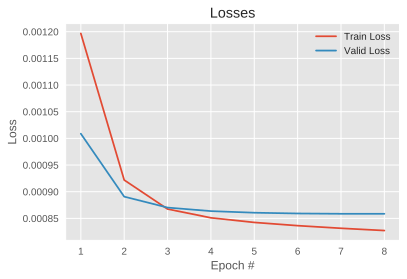

In [136]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

### Check Performance of BoW Model

In [137]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)
        if input_type == 'tdidf':
            inputs = tfidf
            probs = tfidf_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
        
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1550
           1       0.87      0.87      0.87      1557

   micro avg       0.87      0.87      0.87      3107
   macro avg       0.87      0.87      0.87      3107
weighted avg       0.87      0.87      0.87      3107



**Let's check a few examples**

In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, tfidf_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, tfidf_lst, target_lst, text_lst))

def print_random_prediction(model, n=5, input_type='bow'):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, tdidf, target, text = random.choice(test_examples)
            target = target.item()
            
            inputs = bow
            if input_type == 'tdidf':
                inputs = tfidf

            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)
            
            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [139]:
print_random_prediction(bow_model, n=5, input_type='bow')

Number,Review,Predicted,Actual
1,"Yeah, Madsen's character - whilst talking to the woman from the TV station - is right: the LAPD IS a corrupt, violent and racist police. And this movie changes nothing about it. Okay, here are the good cops, the moral cops, even a black one, whow, a Christian, a martyr. But this is a fairy tale, admit it. Reality is not like that. And most important for the action fans: The shoot out is boring. It's just shooting and shooting and shooting. Nothing more. Play Counter Strike, then you will at least have something to do. The only moral of this film is: The LAPD is good now. No more bad cops in it. If you like uncritical, euphemistic commercials for police and military service, watch this movie. It's the longest commercial I've ever seen. (2 Points for camera and editing).",😡,😡
2,"I had heard this film was a study of a landscape photographer's art by presenting the beauty in man's deconstructing the natural landscape. It certainly showed the laborious activities to find locations, setup shots, and capture stark images whose final destinations were art studios worldwide. Put together in moving pictures it is truly a horror show.This film oozes by you supplanting the shock of ghastly images with gentle waves of a wonderful industrial soundtrack that guides you like on slow moving river. Each sequence stands on its own, but in combination you get deeper and deeper into the feeling of overwhelming inevitability. There are few words, this allowing the grandeur in what is shown to preach in its own way. An awful, massive factory filled with human automata who live in hopelessly lifeless dormitories. Individuals dying early while rummaging for recyclable scraps in mountains of our E-waste. The birthing of gigantic ships and their destruction by hand in giant graveyards. The construction of the Three Gorges Dam, the largest industrial project in human history and likely for all time. The time lapse as a city dies and is simultaneously reborn into a replica of modernity that purposefully destroys all relics of the culture that was.The most terrifying image for me was a dam engineer explaining that the most important function of the dam was flood control. The shot shifts to the orchard behind the spokesperson where you witness the level of the last flood by the toxic water having eaten the bark from the trees, demonstrating that nothing but the most hideous vermin could be living in the waters.The obvious not being stated is far more powerful than your normal preachy Save the Earth documentaries. The artist Edward Burtynsky explains the method wonderfully. 'By not saying what you should see Â? many people today sit in an uncomfortable spot where you don't necessarily want to give up what we have but we realize what we're doing is creating problems that run deep. It is not a simple right or wrong. It needs a whole new way of thinking'. The subtlety of this descends into an either/or proposition, but the film images scream that the decision has very much been made in favor of the dark side.Though never stated directly in any way, as the waves of what you witness wash away from your awareness and you contemplate, there is only one conclusion possible Â? we are doomed. The progress of mankind that is inexorable from our natures leaves behind carnage that this artist finds terrifying beauty in. What he is actually capturing are the tracks of we the lemmings rushing unconsciously toward our own demise. Unlike most films with environmental themes, this one ends with no call to arms. It argues basically what's the point, but makes certain you place the blame properly on all of us equally.",😡,😄
3,"This film had me spellbound this evening. Thanks to Fox Movie Classics for showing it uninterrupted. John Voight, this cast of little known black actresses and most of all, the children, made this a worthy way to spend a Sunday evening. How wonderful to see the early work of this seasoned actor, as well as Paul Winfield's 

## TF-IDF Model

**Term Frequency - Inverse Document Frequency**

For a term `i` in document `j`:

$$TFIDF = TF_{i,j} \times log \frac{N}{DF_i}$$

- TF: number of occurance of the term `i` in document `j`
- N: total number of documents
- DF: number of documents containins the term `i`

Questions:
- Why would this be more representative than pure bag of words? 
- What does TFIDF score of a word mean for a document?

### Initialize TF-IDF Model 

In [ ]:
# Define hidden layer size
HIDDEN1 = 100 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = 50 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

In [124]:
tfidf_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
tfidf_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=990, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

### Train TF-IDF Model

TF-IDF vectors as input

In [ ]:
LEARNING_RATE = 5e-5

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, tfidf_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [127]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(tfidf_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(tfidf_model, valid_loader, input_type='tfidf')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 1.31e-03	valid_loss: 1.34e-03

epoch #  2	train_loss: 1.31e-03	valid_loss: 1.34e-03

epoch #  3	train_loss: 1.31e-03	valid_loss: 1.33e-03

epoch #  4	train_loss: 1.31e-03	valid_loss: 1.33e-03

epoch #  5	train_loss: 1.30e-03	valid_loss: 1.32e-03

epoch #  6	train_loss: 1.29e-03	valid_loss: 1.31e-03

epoch #  7	train_loss: 1.28e-03	valid_loss: 1.30e-03

epoch #  8	train_loss: 1.27e-03	valid_loss: 1.29e-03

epoch #  9	train_loss: 1.26e-03	valid_loss: 1.27e-03

epoch # 10	train_loss: 1.24e-03	valid_loss: 1.25e-03

epoch # 11	train_loss: 1.22e-03	valid_loss: 1.23e-03

epoch # 12	train_loss: 1.20e-03	valid_loss: 1.21e-03

epoch # 13	train_loss: 1.18e-03	valid_loss: 1.19e-03

epoch # 14	train_loss: 1.16e-03	valid_loss: 1.16e-03

epoch # 15	train_loss: 1.13e-03	valid_loss: 1.14e-03

epoch # 16	train_loss: 1.11e-03	valid_loss: 1.12e-03

epoch # 17	train_loss: 1.09e-03	valid_loss: 1.10e-03

epoch # 18	train_loss: 1.07e-03	valid_loss: 1.08e-03

epoch # 19	train_loss: 1.05e

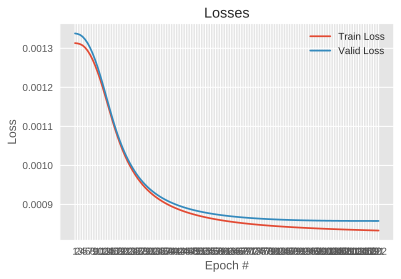

In [130]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

### TF-IDF Performance

In [128]:
tfidf_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = tfidf_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
        
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1529
           1       0.87      0.86      0.87      1578

   micro avg       0.87      0.87      0.87      3107
   macro avg       0.87      0.87      0.87      3107
weighted avg       0.87      0.87      0.87      3107



In [129]:
print_random_prediction(tfidf_model, n=5, input_type='tfidf')

Number,Review,Predicted,Actual
1,"Okay, here's what I think about Jack Frost. I looked at the morphing box for the VHS tape and I thought to myself, this looks interesting. I rent it and I take it home. Boy was I right, it is interesting. They put serial killer's spirits in dreams, in walking corpses and inside every day machines. But this has got to be the most unique place to put the spirit of a serial killer. Inside the body of a snowman. I liked all the friendly snowman images littering the landscape, the pot holder, the snow globe, etc. I like the actor who played Jack, he put some fun into a killer really not seen since FREDDY KRUGGER. That's right, I said it. FREDDY KRUGGER. It's that level of \cool\"". I wish some of the puppet effects were better, the mouth movements could have matched better. But I chalk that up to a small budget. The cast does a great job, there are some great one liners and scares to make any hardcore horror fan jump. All and all, a great story, good effects, great dialog and a great cast. I give JACK FROST...9 STARS""",😄,😄
2,"this was one of the worst movies I've ever seen. I'm still not sure if it was serious, or just a satire. One of those movies that uses every stupid who dunnit clichÃ© they can think of. Arrrrgh.Don Johnson was pretty good in it actually. But otherwise it sucked. It was over 10 years ago that I saw it, but it still hurts and won't stop lingering in my brain. The last line in the movie really sums up how stupid it is. I won't ruin it for you, should you want to tempt fate by viewing this movie. But I garantee you a *nghya* moment at the end, with a few in between. If you have nothing better to do, and you like to point and laugh, then maybe it might be worth your while. Additionally, if you're forced to go on a date with someone you really don't like, suggest watching this movie together, and they'll probably leave you alone after they see it. That's a fair price to pay, I guess.",😡,😡
3,"The movie has a good start portraying an interesting and strong Shannon Lee and introduces two very simpathetic side characters through the first half. But later something happens and all the sudden Shannon turns into this straight faced, second hand bad girl and the movie gets lost in it's own context. The second half lacks any kind of charisma and is full of clichés, bad acting, a horrible plot and even worse stunt coordination. Not to mention the horrible actors they chose for the chechen mafia gang.\Game of Death 2\"" was bad and clownified Bruce, but his daughter tops it making an even bigger embarrassment of herself than the double who played Bruce Lee back then. I truly believe that she can do much better than this and I hope she participates in a better production next time.If you are a real hard core action fan and don't care about quality go ahead and see this movie. I was personally looking forward to it but just got terribly disappointed.""",😡,😡
4,"I just don't know how this stupid, crap, junk, garbage & good for nothing film is a blockbuster. It was so boring with a very, very weak (or no) story-line and wasn't even a jot funny. The film was about 135 minutes of only a paragraph of story about Prem (Salman Khan) is a love guru and is helping hapless & romantic Bhaskar (Govinda) to get the girl he wants. I'm not saying that I didn't like the film because it wasn't funny or anything, I will accept a movie that is not funny but has a decent story. The only two reasons why I can say it's a super-hit are: 1. Salman Khan & Govinda are on-screen together but there first time together was in Salaam e Ishq which was a flop so it can't be. But it was a really good movie.2. Salman Khan's name is Prem and all the films with that name have been a hit including Maine Pyar Kiya. So it's just luck.I heard that it's a remake of Hitch, I've not seen it & I'm glad I didn't. Music is OK the only good songs are Do you want a partner, You're my love & Soni De Nakhre but what is the use of it in a really

## Exercise: Build your own Logistic Regression Text Classifier


- Input: BoW vector or TF-IDF vector
- 1 Affine layer (what are the dimensions of input and output?)
- 1 Sigmoid activation

In [ ]:
## define your affine layer dimension here:


class LogisticRegressionClassifier(nn.Module):
    def __init__(self, device, batch_size, ): # pass layer dimension 
        self.device = device
        ## add affine layer
        
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        ## pass through affine layer & activation

In [ ]:
lr_model = LogisticRegressionClassifier(
    ## your code here
    ##
    device=device,
    batch_size=BATCH_SIZE,
)
lr_model

In [ ]:
LEARNING_RATE = ## give your number
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, lr_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [ ]:
## Run training & validation

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [ ]:
## Run model evaluation

In [ ]:
print_random_prediction(tfidf_model, n=5, input_type='tfidf')